In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
plt.style.use(['science', 'notebook'])
from openpyxl import load_workbook
import imageio
from scipy.interpolate import interp1d, interp2d

Load spreadsheets

In [145]:
def get_data_datasheet(file, sheet, skiprows, usecols, nrows, add_init=None):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy().ravel()
    idx = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    return np.append(add_init[0], idx), np.append(add_init[1], arr), 

def get_interp_datasheet_1D(file, sheet, skiprows, usecols, nrows, add_init=None, scale=1):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy().ravel()/scale
    idx = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    if add_init:
        idx = np.insert(idx,0,add_init[0])
        arr = np.insert(arr,0,add_init[1])
    #return interp1d(idx, arr, kind='linear', bounds_error=False, fill_value=(arr.ravel()[0], arr.ravel()[-1]))
    return np.vectorize(interp1d(idx, arr, kind='linear', bounds_error=False, fill_value='extrapolate'))

def get_interp_datasheet_2D(file, sheet, skiprows, usecols, nrows, scale=1):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy()/scale
    idx1 = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[2], nrows=nrows[2], usecols=usecols[2]).to_numpy().ravel()
    idx2 = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    return np.vectorize(interp2d(idx1, idx2, arr))


Get interpolation functions

In [149]:
# Arguments: rd, d
TMR_int = get_interp_datasheet_2D('DATA1.xlsm', '6 MV TMR', skiprows=[3,3,2],
                                     usecols=['B:K', 'A', 'B:K'], nrows=[40,40,1])
# Arguments: rd
Sp_int = get_interp_datasheet_1D('DATA1.xlsm', 'Linac outputs', skiprows=[28, 27],
                                     usecols=['C:L', 'C:L'], nrows=[1,1])
# Arguments: Yc, Xc
Sc_int = get_interp_datasheet_2D('DATA1.xlsm', 'Linac outputs', skiprows=[3,2,3],
                                 usecols=['D:L', 'D:L', 'C'], nrows=[9,1,9])
# Arguments: r, d
PDD_int = get_interp_datasheet_2D('DATA1.xlsm', '6 MV PDD', skiprows=[3,3,2],
                                     usecols=['B:K', 'A', 'B:K'], nrows=[40,40,1],
                                 scale=100)
# Arguments: d
PDD18_int = get_interp_datasheet_1D('DATA3.xlsm', ' 12-20 MeV PDD', skiprows=[8,8],
                                     usecols=['C', 'A'], nrows=[75,75],
                                 scale=100)
# Arguments: d, x
OAR_int = get_interp_datasheet_2D('DATA2.xlsm', '6 MV OARs', skiprows=[4,4,3],
                                     usecols=['B:E', 'A', 'B:E'], nrows=[21,21,1])

# Question 1

Read in data

In [30]:
d_sup = np.arange(0, 3.5, 0.5)
P_sup = np.array([19.1, 66.8, 85.7, 94.6, 98.8, 99.9, 100])
P_interp = get_interp_datasheet_1D('DATA1.xlsm', '18 MV PDD', skiprows=[3,3],
                          usecols=['F', 'A'], nrows=[40,40],
                         add_init = [d_sup, P_sup])

## Part A

Note that in this problem

* Equal weighting: $D_{Q} = \sum_i D_{Q_i} = D_{Q_1} + D_{Q_2}$
* Equal ${}_{S}D_{N}$ gives $D_{Q_i} = {}_{S}D_{(Q/N)_i} \cdot {}_{S}D_{N_i} = \frac{1}{2} {}_{S}D_{N} \cdot {}_{S}D_{(Q/N)_i}$

So we can plot the dose profile given by

$$\frac{D_{Q}}{{}_{S}D_{N}} = \frac{1}{2}\left({}_{S}D_{(Q/N)_1} + {}_{S}D_{(Q/N)_2} \right)$$

Furthermore, since we are not entering off axis or at an oblique angle, and the $SSD$ is standard, we can express this as 

$$\frac{D_{Q}}{{}_{S}D_{N}} = \frac{1}{2}\left(P(d, 15, 100) + P(22-d, 15, 100) \right)$$

Due to the symmetry of the problem, we need only evaluate this for the first 11cm; the result is mirrored.


In [31]:
d = np.linspace(0, 11, 1000)
dose_profile_f = lambda d: 1/2 * (P_interp(d) + P_interp(22-d))
dose_profile = dose_profile_f(d)
# Mirror over central axis
d= np.append(d, 22-np.flip(d))
dose_profile = np.append(dose_profile, np.flip(dose_profile))

Plot

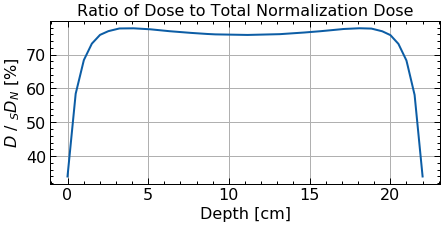

In [32]:
plt.figure(figsize=(7,3))
plt.plot(d, dose_profile)
plt.title('Ratio of Dose to Total Normalization Dose')
plt.xlabel('Depth [cm]')
plt.ylabel('$D~/~{}_{S}D_{N}$ [%]')
plt.grid()
plt.show()

## Part B

We scale the data above so that it corresponds to 2.2Gy at 11cm

In [33]:
dose = dose_profile * 2.2 / dose_profile_f(11)

And then find the maximum

In [34]:
print(f'The maximum dose along the central beam axis is {max(dose):.4f}Gy')

The maximum dose along the central beam axis is 2.2580Gy


## Part C

We extract the value at the surface

In [35]:
print(f'The skin dose on the central beam axis is {dose[0]:.4f}Gy')

The skin dose on the central beam axis is 0.9854Gy


# Question 2

## Part A

Isocentric setups are generally preferred for multiple beam therapy, since the isocenter can be established for all beam directions and the patient does not need to be moved throughout the treatment procedure.

## Part B

* Treatments (orthovoltage) where the target area is at the surface.

* An SSD setup would be preferred if the positioning of an applicator on a patient's body isn't possible due to anatomical limitations. In this case, extended SSD would need to be used.

* For single field treatments, SSD can be used, since there is no benefit to using an SAD formalism (in this case, it doesn't matter).

## Part C

In [36]:
theta = np.arctan(11/16)
d = np.sqrt((11**2+16**2) /4)
x = 16 - d*np.cos(theta)
y = d*np.sin(theta)

Thus, assuming a standard reference frame of $\hat{x}$ pointing towards "LEFT" and $\hat{y}$ pointing up the page, 

In [37]:
print(f'The patient should be moved ({-x}, {-y}) cm')


The patient should be moved (-8.0, -5.5) cm


## Part D

The SSD is given by  $SAD - d$  where $SAD=100$cm and $d$ is the distance from the left setup mark to the treatment isocenter.

In [38]:
SSD = 100 - d
print(f'The source to surface distance is {100-d:.2f}cm')

The source to surface distance is 90.29cm


## Part E

The right lateral setup mark can be used with the left lateral setup mark  to ensure the patient is lying flat before treatment begins.

# Question 3

## Part A

To find the weights, we can use

$$w_i = \left(\sum w_i\right) \frac{D_{Q_i}}{D_Q} $$

Or, if the weights are normalized,

$$w_i = \frac{D_{Q_i}}{\sum D_{Q_i}} $$

Thus we just need to find the normalization dose correpsonding to each row. This is given by

$$D_{N_i} = D_{0(iso)}' \cdot S_c(r_c)S_p(r_d) \cdot WF(\theta, r_c) \cdot  MU_i $$

$$D_{Q_i} = TMR(d_i, r_{d_i}) D_{N_i}$$

since the dose rate is always the same for these points. The equivalent square is $r_d=9.87$ from the data tables. The wedge factor for the 60 degree dynamic wedge is 1.003 from the data tables

In [41]:
ds = np.array([8,9,8,9])
MU = np.array([112,116,133,137])
WFs = np.array([1, 1, 1.003, 1.003])
DQis = 1 * TMR_int(9.870, ds)* Sc_int(16,10) * Sp_int(9.87) * WFs* MU
ws = DQis/DQis.sum()

The weight column is thus:

In [42]:
ws*100

array([22.85500153, 22.85259334, 27.22173526, 27.07066986])

The dose delivered at the isocenter is given by

$$D_Q = \sum_i D_{Q_i}$$

and $r_{d_i}=9.870$ is the equivalent (square) field size at the isocenter of the breast tissue (obtained by converting 7.3 x 16 in data tables).

In [43]:
DQ = sum(DQis)
print(f'Dose delivered to isocenter: {DQ:.3f} cGy')

Dose delivered to isocenter: 417.053 cGy


## Part B

<p align="center">
  <img src="images/a3p1.png" alt="drawing" width="600" align="center"/>
</p>

The beam arrangement shown is ideal because it spares breast tissue that does not need to be irradiated (see upper left). In addition, both beams are sufficiently far from the spinal cord and internal organs.

# Question 4

The setup of the question is as follows

<p align="center">
  <img src="images/a3p2.png" alt="drawing" width="600" align="center"/>
</p>

Let $D^{(1)}$ represent dose from the right beam, $D^{(2)}$ represent dose from the left beam, and $D = D^{(1)} + D^{(2)}$ represent the total dose at any point. We have

* $D_Q = D_Q^{(1)}+D_Q^{(2)} = 3750~\text{cGy}$
* $D_a^{(1)} = 4000~\text{cGy}$

In [66]:
DQ2

36.78248528174936

In [56]:
DQ = 3750 /16
Da1 = 4000 /16
dm = 1.5
dQ = 8
da1 = 3
da2 = 2*dQ - da1
rc1 = 12
r1 = 11
rc2 = 8
r2 = 8
SSD = 100

## Part A

Compute ${}_s D_{(a/N)}^{(1)}$ and use this to get ${}_s D_{N}^{(1)}$

* ${}_s D_{(a/N)}^{(1)}$ only given by PDD here

In [74]:
sDaN_1 = PDD_int(r1, da1)[0]
sDN1 = 1/sDaN_1 * Da1

Use this to get $D_{Q}^{(1)} = {}_s D_{(Q/N)}^{(1)} {}_s D_{N}^{(1)}$

* ${}_s D_{(Q/N)}^{(1)}$ only given by PDD here

In [75]:
sDQN_1 = PDD_int(r1, dQ)[0]
DQ1 = sDN1 * sDQN_1

Use this to get $D_Q^{(2)}$ using $D_Q = D_Q^{(1)} + D_Q^{(2)}$

In [76]:
DQ2 = DQ - DQ1

Use this to get $ {}_s D_{N}^{(2)}$ using $D_{Q}^{(2)} = {}_s D_{(Q/N)}^{(2)} {}_s D_{N}^{(2)}$

* ${}_s D_{(Q/N)}^{(2)}$ only given by PDD here

In [73]:
PDD_int(r1, dQ)[0]

0.7518

In [77]:
sDN2 = DQ2 / PDD_int(r2, dQ)[0]

It follows that

In [78]:
print(f'sDN1 = {sDN1:.2f} cGy per fraction')
print(f'sDN2 = {sDN2:.2f} cGy per fraction')

sDN1 = 262.83 cGy per fraction
sDN2 = 49.71 cGy per fraction


## Part B

We already know $D_a^{(1)}$; we just need $D_a^{(2)}$, which is related to ${}_s D_{N}^{(2)}$ through $D_a^{(2)} = {}_s D_{(a/N)}^{(1)} {}_s D_{N}^{(2)}$

* ${}_s D_{(a/N)}^{(1)}$ given only by PDD in this case

In [50]:
Da2 = PDD_int(r2, da2)[0] * sDN2
Da = Da1 + Da2
print(f'The total dose is {16*Da:.2f} cGy')

The total dose is 4447.75 cGy


## Part C

Let's look at dose along the entire CAX, from left to right (corresponds to figure above)

In [99]:
d2 = np.linspace(dm, 2*dQ-dm, 1000)
d1 = 2*dQ - d2
D = PDD_int(r1, d1) * sDN1 \
    + PDD_int(r2, d2) * sDN2 

Plot

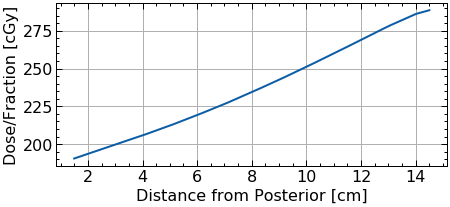

In [101]:
plt.figure(figsize=(7,3))
plt.plot(d2, D)
plt.xlabel('Distance from Posterior [cm]')
plt.ylabel('Dose/Fraction [cGy]')
plt.grid()

As expected, the maximum dose corresponds to $d_m$ from the anterior surface

In [115]:
print(f'The maximum dose along the CAX is {D[-1]:.1f} cGy/fraction ({16*D[-1]:.1f}cGy total)')

The maximum dose along the CAX is 288.5 cGy/fraction (4616.8cGy total)


The off axis ratio can be added to ${}_s D_{(m/N)}^{(i)}$ for each beam ($m$ specifies max dose point)

In [121]:
OAR_int(dm, x2)[0]

1.0094104803493449

In [122]:
x1 = 2
x2 = x1 * (SSD+dm)/SSD * (SSD)/(SSD+2*dQ-dm)
d1 = 1.5
d2 = 2*dQ - 1.5
sDmN_1 = OAR_int(dm, x1)[0]
sDmN_2 = OAR_int(dm, x2)[0] * PDD_int(r2, d2)[0]
D_off = sDmN_1 * sDN1 + sDmN_2 * sDN2
print(f'The off axis dose (x=2cm) at the specified point is {D_off:.2f} cGy/fraction ({16*D_off:.1f}cGy total)')

The off axis dose (x=2cm) at the specified point is 295.39 cGy/fraction (4726.3cGy total)


The dose at the off axis point will be smaller, because this locations is at the edge 8x8cm$^2$ field, meaning it is in the penumbra region (and the dose rapidly decreases here).

The dose at an off axis point of $4~$cm will be greater. This is because the off axis dose increases at $d_m$. The reason this occurs is

* (i) due to scatter in the patient which causes radiation to spread out
* (ii) due to the radial dependence of both fluence and energy fluence in the field at the surface. In particular, the beam is not a constant 6MeV (this is simply the maximum energy), and many of the lower energy photons (which are far more abundant and contribute significantly to the radiation dose) are further from the central axis.

## Part D

Assuming an SSD setup where $\dot{D}_{0,{SSD}} = 1~$cGy/MU we have

$${}_s D_N^{(i)} = S_p(r_d)S_c(r_c) \dot{D}_{0,{SSD}} \cdot MU$$

and we can use this to solve for the monitor units in each case

In [124]:
MU1 = sDN1 / (Sp_int(r1*(SSD+dm)/SSD)[()]*Sc_int(rc1,rc1)[0])
MU2 = sDN2 / (Sp_int(r2*(SSD+dm)/SSD)[()]*Sc_int(rc2,rc2)[0])
print(f'Monitor units from anterior position: {MU1:.1f} MU/fraction ({16*MU1:.1f} MU total)')
print(f'Monitor units from anterior position: {MU2:.1f} MU/fraction ({16*MU2:.1f} MU total)')

Monitor units from anterior position: 260.5 MU/fraction (4167.8 MU total)
Monitor units from anterior position: 50.6 MU/fraction (809.5 MU total)


## Part E

If the maxmimum tissue dose was restricted to 4500cGy, one could give proportionally more radiation from the field pointing at the posterior side. This would involve increasing the number of MU from the "posterior-entering beam", and decreasing the number of MU from the "anterior-entering" beam.

# Question 5

## Part A

The idea is to use the wedges to shield the areas that contain significant "curvature". Such surfaces, which differ significantly from ideal perpendulular and flat surfaces, result in increased surface dose. This is not ideal.

<p align="center">
  <img src="images/a3p3.png" alt="drawing" width="600" align="center"/>
</p>

## Part B

The dose at $Q$ from each field $i$ is

$$D_Q^{(i)} = \frac{w_i}{\sum_i w_i} D_Q $$

This can be used to find $D_{N_i}$

$$D_{Q_i} = TMR(d_i, r_{d_i}) D_{N_i}$$

and then

$$D_N^{(i)} = WF \cdot S_p(r_d)S_c(r_c) \dot{D}_{0,{iso}} \cdot MU$$

assuming that $\dot{D}_{0,{iso}}=1$cGy/MU

In [137]:
SAD = 100
dm = 1.5
ds = np.array([6,7,6,7])
rcs = np.array([(10,16),(10,16),(16,10),(16,10)]) #y,x
rds = np.array([12.200]*4)  
WFs = np.array([1.009, 1.009, 1.006, 1.006])
wis = np.array([75, 75, 25, 25])
DQ = 180

Compute

In [138]:
DQs = wis / sum(wis) * DQ
DNis = DQs / TMR_int(rds, ds)
MUs = DNis / (WFs * Sp_int(rds) * Sc_int(rcs[:,0], rcs[:,1]))

In order of rows 1 to 4, the number of monitor units required is thus:

In [139]:
[print(f'Number of monitor units for field {i}: {MUs[i]:.3f} MU') for i in range(4)];

Number of monitor units for field 0: 73.241 MU
Number of monitor units for field 1: 75.553 MU
Number of monitor units for field 2: 24.327 MU
Number of monitor units for field 3: 25.095 MU


# Question 8

## Part A

Note that $d=0.5$cm gives 95\%

In [164]:
PDD18_int(0.5)[()]

0.95

## Part B

$${}_s D_N = S_p(r_d)S_c(r_c) \dot{D}_{0,{SSD}} \cdot MU$$